# Denoising Sentinel-1 Image
This notebook demontrates using Park et al denoising algorithm to remove thermal noise from a Sentinel-1 HV image.

The `s1denoise` algorithm is used.

https://github.com/andypbarrett/sentinel1denoised

In [55]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from s1denoise import Sentinel1Image

from astropy.visualization import simple_norm

In [2]:
DATAPATH = Path('/home', 'apbarret', 'Data', 'Sentinel-1')
IMAGEPATH = DATAPATH / 'S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631.zip'

Image data and annotations are read into a `Sentinel1Image` object.  This is a `python` class with attributes and methods, including denoising methods.  Currently, it takes a file path argument as a `str` object.  Auxillary calibration files are downloaded and applied automatically. 

In [3]:
s1 = Sentinel1Image(str(IMAGEPATH))

02:26:52|40|nansat|_get_dataset_metadata|GDAL could not open /home/apbarret/Data/Sentinel-1/S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631.zip, trying to read with Nansat mappers...


In [4]:
help(s1)

Help on Sentinel1Image in module s1denoise.sentinel1image object:

class Sentinel1Image(nansat.nansat.Nansat)
 |  Sentinel1Image(filename, mapperName='sentinel1_l1', logLevel=30)
 |  
 |  Cal/Val routines for Sentinel-1 performed on range noise vector coordinatess
 |  
 |  Method resolution order:
 |      Sentinel1Image
 |      nansat.nansat.Nansat
 |      nansat.domain.Domain
 |      nansat.exporter.Exporter
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename, mapperName='sentinel1_l1', logLevel=30)
 |      Read calibration/annotation XML files and auxiliary XML file
 |  
 |  calibrate_noise_vectors(self, noise, cal_s0, scall)
 |      Compute calibrated NESZ from input noise, sigma0 calibration and scalloping noise
 |  
 |  compute_rqm(self, s0, polarization, line, pixel, num_px=100, **kwargs)
 |      Compute Range Quality Metric from the input sigma0
 |  
 |  download_aux_calibration(self, filename, platform)
 |      Download auxiliary calibration 

Bands, including DN (digital numbers), calibrated normalized radar cross section ($\sigma0$ `sigma0_hv`), and noise equivalent vectors are accessed as list items - this is a feature of the `NanSat` package.  A full list of bands can ge obtained using the `list_bands` method.

In [5]:
s1.list_bands()

Band : 1 DN_HH
  dataType: 2
  name: DN_HH
  SourceBand: 1
  SourceFilename: /vsizip//home/apbarret/Data/Sentinel-1/S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631.zip/S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631.SAFE/measurement/s1a-ew-grd-hh-20201216t172339-20201216t172439-035714-042de8-001.tiff
Band : 2 DN_HV
  dataType: 2
  name: DN_HV
  SourceBand: 1
  SourceFilename: /vsizip//home/apbarret/Data/Sentinel-1/S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631.zip/S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631.SAFE/measurement/s1a-ew-grd-hv-20201216t172339-20201216t172439-035714-042de8-002.tiff
Band : 3 sigmaNought_HH
  dataType: 7
  name: sigmaNought_HH
  SourceBand: 1
  SourceFilename: /vsimem/M3EWML4AQT.vrt
Band : 4 noise_HH
  dataType: 7
  name: noise_HH
  SourceBand: 1
  SourceFilename: /vsimem/KTDSR8820M.vrt
Band : 5 sigmaNought_HV
  dataType: 7
  name: sigmaNought_HV
  SourceBand: 1
  SourceFilenam

The `get_band_number` can be used to return the list index for a given band id (name).  Bands are returned as `numpy` arrays.

In [46]:
sigma0_hv = s1[s1.get_band_number(band_id='sigma0_HV')]
nesz_hv = s1.get_nesz_full_size('HV')

In [47]:
nesz_hv.min(), nesz_hv.max()

(0.0003392084435088825, 0.007895739271515545)

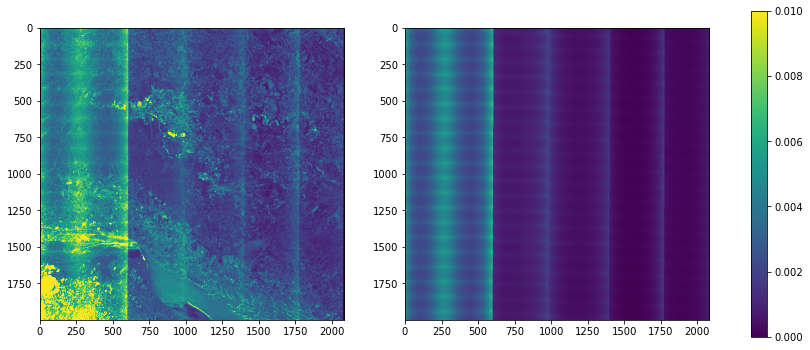

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
cimg = ax[0].imshow(sigma0_hv[::5,::5], vmax=0.01)
nimg = ax[1].imshow(nesz_hv[::5, ::5], vmax=0.01)
fig.colorbar(cimg, ax=ax, shrink=0.6)

The `remove_thermal_noise` method removes the scaled thermal noise vector from the calibrated `sigma0` field.  There is also a `remove_texture_noise` method, which removes thermal noise following Park et al and smooths the residual noise.

In [8]:
sigma0_hv_denoise = s1.remove_thermal_noise('HV')
sigma0_hv_detexture = s1.remove_texture_noise('HV')

Text(0.5, 1.0, 'remove_texture_noise')

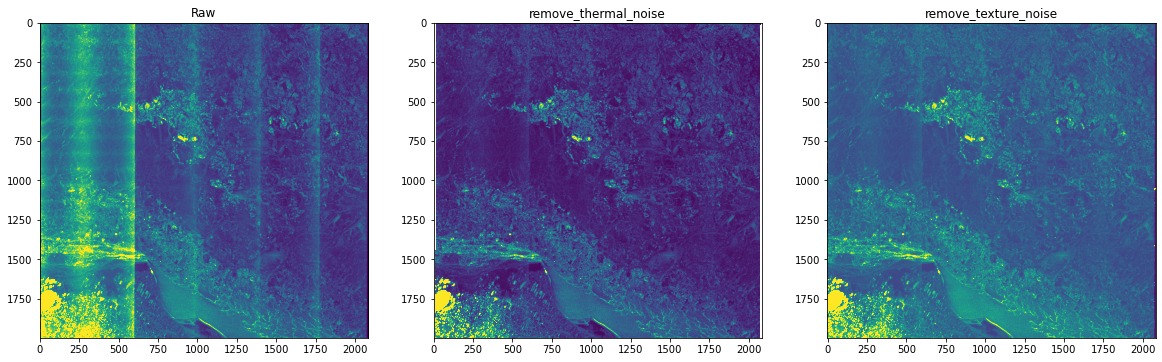

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,12))
ax[0].imshow(sigma0_hv[::5,::5], vmax=0.01)
ax[0].set_title('Raw')

ax[1].imshow(sigma0_hv_denoise[::5, ::5], vmax=0.01)
ax[1].set_title('remove_thermal_noise')

ax[2].imshow(sigma0_hv_detexture[::5, ::5], vmax=0.01)
ax[2].set_title('remove_texture_noise')

In [10]:
texture_minus_thermal = sigma0_hv_detexture - sigma0_hv_denoise

In [133]:
np.nanmin(texture_minus_thermal), np.nanmax(texture_minus_thermal)

(-0.012135261700627717, 0.004018507212284265)

In [32]:
vmin = 0.001
vmax = 0.002
norm = simple_norm(texture_minus_thermal, min_cut=vmin, max_cut=vmax, stretch='power')

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(texture_minus_thermal[::5,::5], norm=norm)
ax.set_title('texture - thermal')

The "detextured" mean azimuth profile has some additional noise from boundary pixels.  As a quick-and-dirty solution, I only plot range pixels for the interval [200:-200]

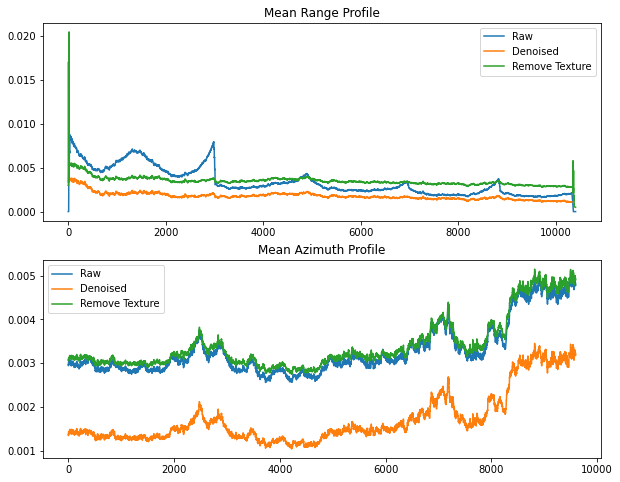

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(sigma0_hv.mean(axis=0), label='Raw')
ax[0].plot(sigma0_hv_denoise.mean(axis=0), label='Denoised')
ax[0].plot(np.nanmean(sigma0_hv_detexture, axis=0), label='Remove Texture')
ax[0].set_title('Mean Range Profile')
ax[0].legend()

ax[1].plot(sigma0_hv[200:-200, 200:-200].mean(axis=1), label='Raw')
ax[1].plot(np.nanmean(sigma0_hv_denoise[200:-200, 200:-200], axis=1), label='Denoised')
ax[1].plot(np.nanmean(sigma0_hv_detexture[200:-200, 200:-200], axis=1), label='Remove Texture')
ax[1].set_title('Mean Azimuth Profile')
ax[1].legend()

## Sun et al - Calculate Kns,ssw
- Mask land
- Calculate noise scaling for each subswath block following Park et al
$$
s(k) = \sigma^{0}_{SN} - k \times G_{ds} \cdot \sigma^{0}_{N} \\
RSS(k) = \sum_{i=1}^{N} \omega_{i}(\hat{s_{i}}(k) - s_{i}(k))^2 \\
min\{k \in R|RSS(k)\} \rightarrow K_{ns,ssw} = k
$$

### Calculate raw - nesz fields first
`raw` and `nesz` bounday pixels (within 200 pixels of edge) are set to NaN. 

In [71]:
nesz_scaled = s1.get_corrected_nesz_full_size('HV', nesz_hv)

/tmp/ipykernel_15414/223622312.py:20: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(corrected, axis=0), label='Corrected')
/tmp/ipykernel_15414/223622312.py:21: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(raw, axis=0), label='Raw')
/tmp/ipykernel_15414/223622312.py:22: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(nesz, axis=0), label='NESZ')
/tmp/ipykernel_15414/223622312.py:23: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(nesz_scaled, axis=0), label='NESZ scaled')
/tmp/ipykernel_15414/223622312.py:27: RuntimeWarning: Mean of empty slice
  ax3.plot(np.nanmean(corrected, axis=1), label='Corrected')
/tmp/ipykernel_15414/223622312.py:28: RuntimeWarning: Mean of empty slice
  ax3.plot(np.nanmean(raw, axis=1), label='Raw')
/tmp/ipykernel_15414/223622312.py:29: RuntimeWarning: Mean of empty slice
  ax3.plot(np.nanmean(nesz, axis=1), label='NESZ')


Text(0.5, 1.0, 'Mean Azimuth Profile')

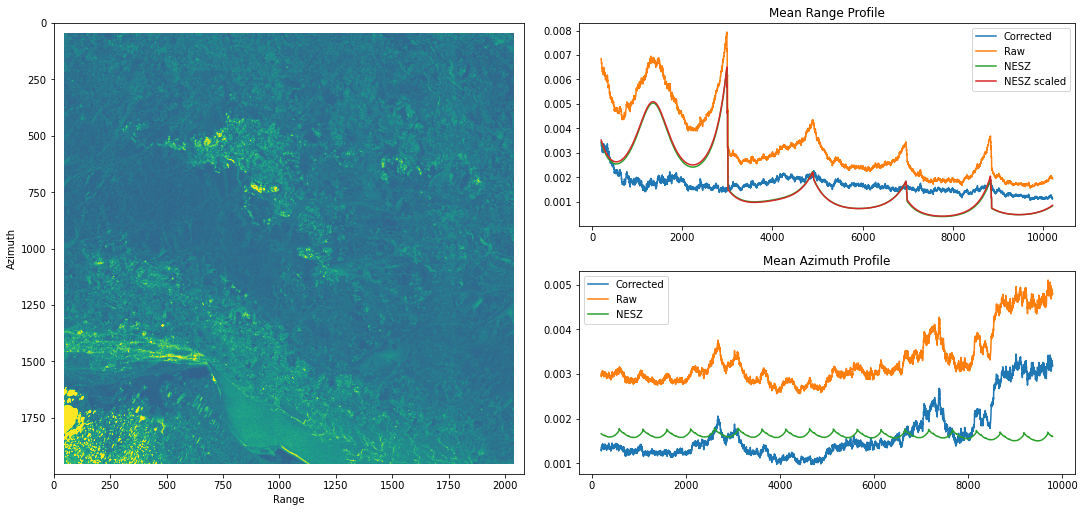

In [73]:
mask = np.full(sigma0_hv.shape, True, dtype=bool)
mask[200:-200, 200:-200] = False

raw = np.where(mask, np.nan, sigma0_hv)
nesz = np.where(mask, np.nan, nesz_hv)
nesz_scaled = np.where(mask, np.nan, nesz_scaled)

corrected = raw - nesz

fig = plt.figure(figsize=(15,7), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0:2,0:2])
ax2 = fig.add_subplot(spec[0,2:])
ax3 = fig.add_subplot(spec[1,2:])

ax1.imshow(corrected[::5,::5], vmax=0.01)
ax1.set_ylabel('Azimuth')
ax1.set_xlabel('Range')

ax2.plot(np.nanmean(corrected, axis=0), label='Corrected')
ax2.plot(np.nanmean(raw, axis=0), label='Raw')
ax2.plot(np.nanmean(nesz, axis=0), label='NESZ')
ax2.plot(np.nanmean(nesz_scaled, axis=0), label='NESZ scaled')
ax2.legend()
ax2.set_title('Mean Range Profile')

ax3.plot(np.nanmean(corrected, axis=1), label='Corrected')
ax3.plot(np.nanmean(raw, axis=1), label='Raw')
ax3.plot(np.nanmean(nesz, axis=1), label='NESZ')
ax3.legend()
ax3.set_title('Mean Azimuth Profile')



As a test, run for EW1.  Run for a full subswath first.  This is what Park does.

In [126]:
subswath = 'EW1'
swath_bounds = s1.import_swathBounds('HV')[subswath]

firstAzimuthLine = swath_bounds['firstAzimuthLine']
lastAzimuthLine = swath_bounds['lastAzimuthLine']
firstRangeSample = swath_bounds['firstRangeSample']
lastRangeSample = swath_bounds['lastRangeSample']
print(lastRangeSample)

[3010, 3002, 2995, 2988]


`experiment_noiseScaling` is the function to estimate scaling parameters.  It writes results to a file but could be written to dictionary.

From the code - every other pixel in a range profile is used to estimate noise vector.  This might not work for Sun because they use variance to discard azimuth lines. 

In [130]:
from scipy.interpolate import interp1d

line, pixel0, noise0 = s1.get_noise_range_vectors('HV')

p = pixel0[0]
n = noise0[0]

interp1d(p, n)

In [114]:
s1.experiment_noiseScaling('HV', average_lines=200)

In [115]:
f = np.load('S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631_noiseScaling.npz', allow_pickle=True)

In [123]:
f['EW1'].tolist()['sigma0'][0].shape

(1306,)

_Why are subswaths divided into blocks?_

In [117]:
sigma0_hv.shape[0] / 200

49.955

In [46]:
sigma0_hv_sub = sigma0_hv[firstAzimuthLine[0]:lastAzimuthLine[0]+1, firstRangeSample[0]:lastRangeSample[0]+1]
sigma0_hv_sub.shape

(3407, 3011)

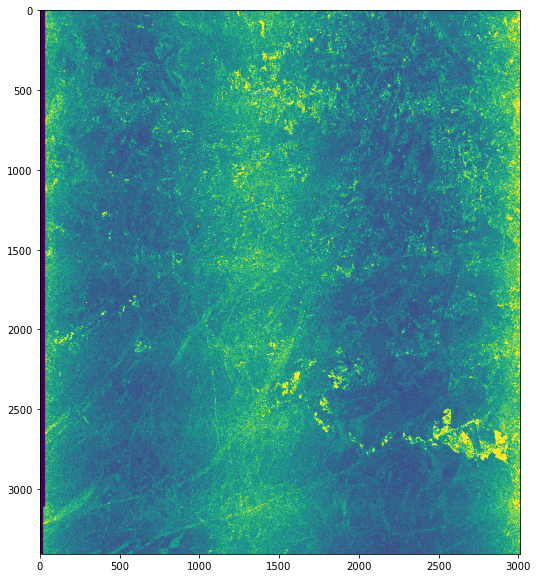

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(sigma0_hv_sub, vmax=0.01)

- Divide subswath element into blocks with 200 azimuth lines - 
- Calculate noise scaling factor

In [58]:
nazimuth, nrange = sigma0_hv_sub.shape

In [59]:
def get_azimuth_samples(nazimuth):
    result = np.arange(0, nazimuth, 200)
    if nazimuth - result[-1] > 10:
        result = np.append(result, nazimuth)
    return result

In [61]:
samples = get_azimuth_samples(nazimuth)

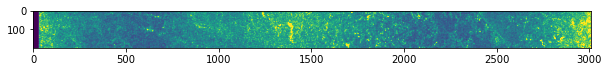

In [62]:
i=0
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(sigma0_hv_sub[:samples[i+1]], vmax=0.01)

In [66]:
geolocationGridPoint = s1.import_geolocationGridPoint('HV')

In [86]:
rawLatitude = np.array(geolocationGridPoint['latitude']).reshape(21,21).round(5)
rawLongitude = np.array(geolocationGridPoint['longitude']).reshape(21,21).round(5)

In [89]:
corrected_path = Path('S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631_old',
                      'S1A_EW_GRDM_1SDH_20201216T172339_20201216T172439_035714_042DE8_E631_Orb.data',
                      'tie_point_grids')
latfile_orb = DATAPATH / corrected_path / 'latitude.img'
lonfile_orb = DATAPATH / corrected_path / 'longitude.img'

corrLatitude = np.fromfile(latfile_orb, dtype='>f4').reshape(21,21)
corrLongitude = np.fromfile(lonfile_orb, dtype='>f4').reshape(21,21)

In [90]:
rawLongitude[0,:]

array([-149.46225, -150.06942, -150.68186, -151.29953, -151.92235,
       -152.55025, -153.18316, -153.821  , -154.46367, -155.11108,
       -155.76313, -156.41971, -157.08072, -157.74603, -158.41551,
       -159.08905, -159.76649, -160.44771, -161.13255, -161.82085,
       -162.50182])

In [91]:
corrLongitude[0,:]

array([-149.46225, -150.06902, -150.68105, -151.29828, -151.92067,
       -152.54814, -153.18062, -153.818  , -154.4602 , -155.10716,
       -155.75874, -156.41486, -157.0754 , -157.74022, -158.40921,
       -159.08226, -159.75922, -160.43993, -161.12427, -161.81206,
       -162.50182], dtype=float32)

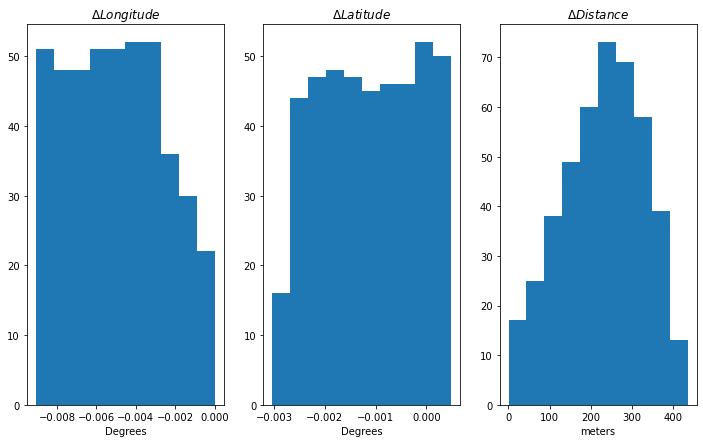

In [118]:

diffLongitude = rawLongitude.reshape(-1) - corrLongitude.reshape(-1)
diffLatitude = rawLatitude.reshape(-1) - corrLatitude.reshape(-1)

fig, ax = plt.subplots(1, 3, figsize=(12, 7))
ax[0].hist(diffLongitude);
ax[0].set_title('$\Delta Longitude$');
ax[0].set_xlabel('Degrees');

ax[1].hist(diffLatitude);
ax[1].set_title('$\Delta Latitude$');
ax[1].set_xlabel('Degrees');

ax[2].hist(distance);
ax[2].set_title('$\Delta Distance$');
ax[2].set_xlabel('meters');

fig.savefig('effect_of_updated_orbit_file.png')

In [103]:
import pyproj

In [105]:
geod = pyproj.Geod(ellps='WGS84')

In [111]:
distance = []
for rlon, rlat, clon, clat in zip(rawLongitude.reshape(-1), rawLatitude.reshape(-1), corrLongitude.reshape(-1), corrLatitude.reshape(-1)):
    _, _, dist = geod.inv(rlon, rlat, clon, clat)
    distance.append(dist)
    
distance = np.array(distance)
distance.min(), distance.max()

(0.41138850847755104, 435.3889818053423)

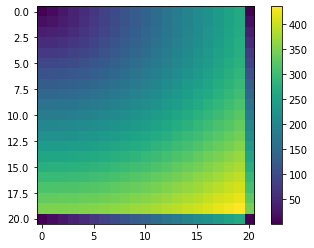

In [113]:
img = plt.imshow(distance.reshape(21,21))
plt.colorbar(img)